注解：
1. 好像是用sklearn的随机森林分类器做点云分类，并没有使用深度学习; 
3. 用[pyntcloud](https://github.com/daavoo/pyntcloud)提取了各种各样的特征； 
4. 17个类别,使用的数据集：[Paris-rue-Madame database](http://cmm.mines-paristech.fr/Projects/TerraMobilita/rueMadame_database.zip)，数据集是两个ply文件分别充当训练集和测试集，都是1千万个点，排除地面点和默认点，剩下90万个点   


2019.03.14 调通，测试集 Accuracy: 0.9174709432905417

![Point Cloud](.\docu\Paris-rue-Madame-database.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyntcloud import PyntCloud
from pyntcloud import scalar_fields
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors.kde import KernelDensity

In [2]:
def preProcessData(cld):
    ##Cacluate 50 neighbours for determining the geometrical features of each point
    neigh=cld.get_neighbors(k=50)
    neigh.shape
    
    #注释的特征暂未使用，因为计算量有点大，目前只有geometrical features使用
    '''
    #kde=KernelDensity(kernel='gaussian',bandwidth=0.2).fit(cld.points[['x','y','z']])
    #density=kde.score_samples(cld.points[['x','y','z']])
    #cld.points.add(density,axis=1)

    #vox=cld.add_structure("voxelgrid")
    #vox_x=cld.add_scalar_field("voxel_x",voxelgrid_id=vox)
    #vox_y=cld.add_scalar_field("voxel_y",voxelgrid_id=vox)
    #vox_n=cld.add_scalar_field("voxel_n",voxelgrid_id=vox)
    #vox_z=cld.add_scalar_field("voxel_z",voxelgrid_id=vox)
    #inc=cld.add_scalar_field("inclination_degrees")
    #ori=cld.add_scalar_field("orientation_degrees")
    '''
    eig=   cld.add_scalar_field("eigen_values",k_neighbors=neigh)
    ani=   cld.add_scalar_field("anisotropy",ev=eig)
    cur=   cld.add_scalar_field("curvature",ev=eig)
    eigent=cld.add_scalar_field("eigenentropy",ev=eig)
    su=    cld.add_scalar_field("eigen_sum",ev=eig)
    lin=   cld.add_scalar_field("linearity",ev=eig)
    om=    cld.add_scalar_field("omnivariance",ev=eig)
    pla=   cld.add_scalar_field("planarity",ev=eig)
    sph=   cld.add_scalar_field("sphericity",ev=eig)
    return cld

# 训练集数据

In [3]:
## 加载训练集点云文件，加载后为pandas dataframe
#cloud_train=PyntCloud.from_file("./data/yupont/cz_1-9-ml.ply")
cloud_train=PyntCloud.from_file("./data/yupont/cz_1-9-ml.csv",
            sep=",", header=0, names=["x","y","z","R","G","B",
                                      "PointSourceId","ScanAngleRank",
                                      "ScanDirectionFlag","reflectance",
                                      "ReturnNumber","label","class"])
print(cloud_train)

PyntCloud
858414 points with 10 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 588568.4603814572, 3415908.319845691, 52.49932002977977
Other attributes:



In [4]:
cloud_train.points.head()

,x,y,z,R,G,B,PointSourceId,ScanAngleRank,ScanDirectionFlag,reflectance,ReturnNumber,label,class
0,588532.900024,3.415956e+06,64.720001,0,0,0,6.0,0,0,2.0,1.0,38.0,16.0
1,588533.000031,3.415956e+06,64.820000,0,0,0,6.0,0,0,2.0,1.0,71.0,16.0
2,588533.120026,3.415956e+06,64.770004,0,0,0,6.0,0,0,2.0,1.0,165.0,16.0
3,588533.190033,3.415956e+06,64.739998,0,0,0,6.0,0,0,2.0,1.0,80.0,16.0
4,588533.280029,3.415956e+06,64.809998,0,0,0,6.0,0,0,2.0,1.0,14.0,16.0


In [6]:
cloud_train.points.rename(columns={
    "scalar_Scalar_field_#7":'class',
    "scalar_Scalar_field_#6":'label',
    "scalar_Scalar_field_#5":'reflectance'},inplace=True)

cloud_train.points.drop(labels=["R","G","B","ScanAngleRank","PointSourceId","ScanDirectionFlag","ReturnNumber"],inplace=True,axis=1)

cloud_train.points.head()

,x,y,z,reflectance,label,class
0,588532.900024,3.415956e+06,64.720001,2.0,38.0,16.0
1,588533.000031,3.415956e+06,64.820000,2.0,71.0,16.0
2,588533.120026,3.415956e+06,64.770004,2.0,165.0,16.0
3,588533.190033,3.415956e+06,64.739998,2.0,80.0,16.0
4,588533.280029,3.415956e+06,64.809998,2.0,14.0,16.0


In [7]:
cloud_train.points.describe()

,x,y,z,reflectance,label,class
count,858414.000000,8.584140e+05,858414.000000,858414.000000,858414.000000,858414.000000
mean,588568.460381,3.415908e+06,52.499320,1.458038,188.431102,3.662884
std,18.605081,3.288761e+01,2.801689,0.558350,41.526994,1.500418
min,588532.880035,3.415827e+06,45.310001,1.000000,10.000000,2.000000
25%,588553.660034,3.415884e+06,51.150002,1.000000,162.000000,3.000000
50%,588569.050034,3.415911e+06,52.439999,1.000000,205.000000,4.000000
75%,588583.510025,3.415936e+06,54.010002,2.000000,217.000000,4.000000
max,588601.170029,3.415963e+06,77.779999,3.000000,276.000000,20.000000


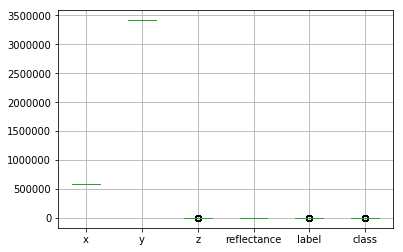

In [8]:
cloud_train.points.boxplot() # 图形化展示describe()

In [9]:
##Visualization of point cloud
# cloud_train.plot()

# 点云地物分类标准 
1默认点，2地面点，345-低中高，7低噪，8关键，9临建，10桥梁，
11铁路，12公路，13不河流，14湖泊，15变电站，16导线，17铁塔
18交跨上，19交跨下，20地线，21其他，22船舶汽车，23其他线路
24共塔其他线，25通航河流，26铁路承力索，27引流线，28绝缘子

In [12]:
# 排除地面点和默认点
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=2])
cloud_train=PyntCloud(cloud_train.points[cloud_train.points["class"]!=1])

In [13]:
#用open3做三维网格下采样 voxel grid downsampling
#open3d.voxelgrid_downsampling(cloud,voxel=0.5)
cloud_train.points["class"].value_counts()

4.0     418676
3.0     207484
5.0      80790
8.0       8045
17.0      2687
16.0      2272
20.0      1103
Name: class, dtype: int64

In [14]:
# cloud_train.plot()

In [15]:
# 清理掉标签数据,防止数据泄露
cloud_train_target=cloud_train.points["class"]
cloud_train.points.drop(labels=["class"],inplace=True,axis=1)

cloud_train_pp = preProcessData(cloud_train)
cloud_train_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_train_pp.points.drop(labels=["x","y","z","reflectance"],inplace=True,axis=1)
cloud_train_pp.points.head()
#cloud_train_pp.points.to_csv("features_calculated_train.csv",index=False)

In [16]:
cloud_train_pp.points.describe()
# sklearn的随机森林分类器
rfc = RandomForestClassifier()

In [17]:
rfc.fit(cloud_train_pp.points,cloud_train_target)

/home/huhongjun/anaconda2/envs/urban/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
# 预测训练数据
prediction=rfc.predict(cloud_train.points)
print("Accuracy:",accuracy_score(cloud_train_target,prediction))

Accuracy: 0.976527514468343


In [19]:
import pickle
filename = "random_forest.sav"
pickle.dump(rfc,open(filename,'wb'))

rfc_model = pickle.load(open("random_forest.sav","rb"))

# Test Set Evaluation

In [13]:
import pickle
rfc_model = pickle.load(open("random_forest-201903280151.sav","rb"))

In [3]:
# 测试集数据

cloud_test=PyntCloud.from_file("./data/yupont/cz_1-9_buildings2.las")
print(cloud_test)

#cloud_test.plot()

PyntCloud
1133888 points with 10 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 120.52012755394719, 63.5133796625337, 12.194775588378619
Other attributes:
	 las_header: <class 'laspy.header.HeaderManager'>



In [7]:
cloud_test.points.head()


,x,y,z,label,reflectance,class,scan_angle_rank,user_data,pt_src_id,gps_time,red,green,blue
0,162.449997,1.480003,18.179998,175,9,6,0,1,2,458929.6574,36864,37888,37632
1,162.180000,1.459999,18.210001,135,9,6,0,1,2,458929.6684,36608,37888,37632
2,162.239998,1.540001,18.219999,144,9,6,0,1,2,458929.6684,40192,41984,40960
3,162.300003,1.620003,18.250002,190,9,6,0,1,2,458929.6684,39424,40192,39680
4,162.360001,1.699997,18.280001,150,9,6,0,1,2,458929.6684,35840,36864,36096


In [ ]:
cloud_test.points.rename(columns={
    "raw_classification":'class',
    "intensity":'label',
    "flag_byte":'reflectance'},inplace=True)

In [8]:
cloud_test.points.drop(labels=["red","green","blue","scan_angle_rank","user_data","pt_src_id","gps_time"],inplace=True,axis=1)

cloud_test.points.head()

,x,y,z,label,reflectance,class
0,162.449997,1.480003,18.179998,175,9,6
1,162.180000,1.459999,18.210001,135,9,6
2,162.239998,1.540001,18.219999,144,9,6
3,162.300003,1.620003,18.250002,190,9,6
4,162.360001,1.699997,18.280001,150,9,6


In [9]:
cloud_test.points["class"].value_counts()

5     429346
4     363239
3     277037
18     23418
8      18399
6       9436
17      6306
16      3331
19      1778
20      1598
Name: class, dtype: int64

测试集数据同样需要做数据预处理，提取相关特征。

In [20]:
#Downsampling not required as the dataset is already cleaned
#voxel grid downsampling will be done here
#open3d.voxelgrid_downsampling(cloud1,voxel=0.5)
#p linkage segmentation and shape distribution histogram

In [10]:
#cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=2])
#cloud_test=PyntCloud(cloud_test.points[cloud_test.points["class"]!=1])

cloud_test_target=cloud_test.points["class"]
cloud_test.points.drop(labels=["class"],inplace=True,axis=1)

cloud_test_pp = preProcessData(cloud_test)
cloud_test_pp.points.drop(labels=["label"],inplace=True,axis=1)
cloud_test_pp.points.drop(labels=["x","y","z","reflectance"],inplace=True,axis=1)  

In [11]:
cloud_test_pp.points.head()

,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
0,0.127866,0.043123,0.000088,0.999309,0.000516,0.399382,0.171077,0.662748,0.007868,0.336562,0.000691
1,0.135605,0.039848,0.000102,0.999251,0.000579,0.400292,0.175554,0.706145,0.008187,0.293106,0.000749
2,0.115700,0.044413,0.000076,0.999340,0.000477,0.388571,0.160189,0.616140,0.007320,0.383200,0.000660
3,0.107751,0.047999,0.000087,0.999192,0.000559,0.386627,0.155836,0.554539,0.007665,0.444653,0.000808
4,0.089657,0.057329,0.000096,0.998927,0.000654,0.381020,0.147081,0.360576,0.007907,0.638352,0.001073


In [14]:
prediction_test=rfc_model.predict(cloud_test_pp.points)
print("Accuracy:",accuracy_score(cloud_test_target,prediction_test))

Accuracy: 0.37351572642095165
